In [49]:
import pandas as pd
import h3.api.numpy_int as h3

import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from shapely.geometry import Polygon, Point
import seaborn as sns
import re

import stc_unicef_cpi.data.get_satellite_data as ge
import stc_unicef_cpi.data.make_dataset as md
import stc_unicef_cpi.utils.general as g
import stc_unicef_cpi.utils.constants as c

import stc_unicef_cpi.utils.geospatial as geo
import stc_unicef_cpi.utils.clean_text as ct

In [27]:
read_path = '/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/data'

In [28]:
raw = pd.read_csv(read_path + '/raw/childpoverty_microdata_gps_21jun22.csv')

/tmp/ipykernel_354/2679583450.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(read_path + '/raw/childpoverty_microdata_gps_21jun22.csv')


In [ ]:
hexes_dhs = pd.read_csv(read_path + '/processed/20221025_hexes_dhs.csv', dtype={'hex_code':int})

In [44]:
pd.set_option("display.max_columns", 200)

# Years of DHS surveys

In [12]:
countries_ssf = ['Angola', 
            'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
            'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, The Democratic Republic of the', 'Congo', "Côte d'Ivoire",
            'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 
            'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
            'Kenya', 
            'Lesotho', 'Liberia', 
            'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique',
            'Namibia', 'Niger', 'Nigeria',
            'Rwanda', 
            'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'Sudan', 'South Sudan', 
            'Tanzania, United Republic of', 'Togo', 
            'Uganda',
            'Zambia', 'Zimbabwe']

In [16]:
countries_dhs = pd.DataFrame(columns=['country', 'country_code', 'dhs_children', 'dhs_year', 'mics_children', 'mics_year'])

for country in countries_ssf:
    country_code = ct.get_alpha3_code(country)

    if country_code in list(raw['countrycode']):
        subset = raw[raw['countrycode']==country_code]
        # print('check if there are nan values')
        # print(subset['deprived_sev'].value_counts())
        dhs = subset[subset.survey=='DHS']
        if dhs.shape[0]!= 0:
            year_dhs = dhs.year.mean()
            num_dhs = dhs.shape[0]
        else:
            year_dhs, num_dhs = 0, 0

        mics = subset[subset.survey=='MICS']
        if mics.shape[0]!= 0:
            year_mics = mics.year.mean()
            num_mics = mics.shape[0]
        else:
            year_mics, num_mics = 0, 0

        countries_dhs = countries_dhs.append({'country':country,  'country_code':country_code, 'dhs_children': num_dhs, 'dhs_year':year_dhs, 
                    'mics_children':  num_mics,   'mics_year': year_mics}, ignore_index=True)
    
        

In [19]:
country_mics = countries_dhs[countries_dhs['mics_children']!= 0].copy()
countries_dhs = countries_dhs[countries_dhs['dhs_children']!= 0].copy()

In [23]:
country_mics

,country,country_code,dhs_children,dhs_year,mics_children,mics_year
5,Central African Republic,CAF,0,0.0,25430,2019.0
6,Chad,TCD,0,0.0,67164,2019.0
8,"Congo, The Democratic Republic of the",COD,53868,2013.0,57566,2018.0
9,Congo,COG,0,0.0,26691,2015.0
10,Côte d'Ivoire,CIV,0,0.0,28377,2016.0
11,Eswatini,SWZ,0,0.0,10131,2014.0
13,Gambia,GMB,0,0.0,32786,2018.0
14,Ghana,GHA,0,0.0,30663,2017.0
16,Guinea-Bissau,GNB,0,0.0,24206,2019.0
18,Lesotho,LSO,16898,2014.0,13989,2018.0


In [14]:
# countries_dhs = pd.read_csv('/mnt/c/Users/vicin/Desktop/DSSG/Data/Tables tesi/countries_with_output.csv', dtype = {'DHS year':int})
# countries_dhs = countries_dhs.rename(columns = {'Country':'country', 'Code':'country_code', 'DHS year':'dhs_year', 'Number of children with DHS':'dhs_children'})
countries_dhs.head(3)

,country,country_code,dhs_children,dhs_year,num hex with output,num hex with neigh,tot
0,Angola,AGO,42167,2015,519,6050,220183
1,Benin,BEN,40064,2017,475,5065,28345
2,Burkina Faso,BFA,44464,2010,501,7154,67132


In [38]:
# ctry_code = ct.get_alpha3_code('')
shpfilename = shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )

# read the shapefile using geopandas
world = gpd.read_file(shpfilename)

# select countries in Africa
africa = world[world['CONTINENT'] == "Africa"]

In [4]:
africa.head(2)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
13,Admin-0 country,0,2,Ethiopia,ETH,0,2,Sovereign country,1,Ethiopia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((34.07070 9.45459, 34.06689 9.53118, ..."
14,Admin-0 country,0,3,South Sudan,SDS,0,2,Sovereign country,1,South Sudan,...,None,None,None,None,None,None,None,None,None,"POLYGON ((35.92084 4.61933, 35.85654 4.61960, ..."


In [5]:
to_plot = africa.merge(countries_dhs, how='left', right_on = 'country_code', left_on = 'ADM0_ISO')
to_plot = to_plot[to_plot.country_code.isna()==False].copy()
to_plot['dhs_year'] = to_plot['dhs_year'].apply(lambda x: int(x))
print(to_plot.shape)

(25, 176)


In [6]:
sorted(to_plot.dhs_year.unique())

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

Countries with DHS surveys and the latest year it was done


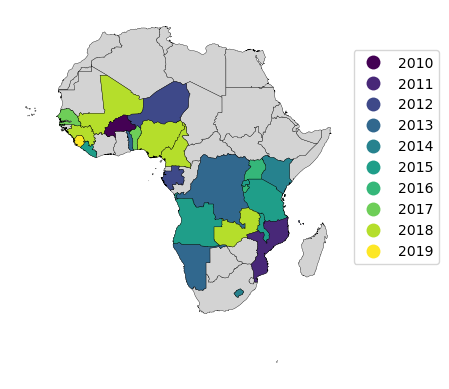

In [7]:
fig, ax = plt.subplots()# dpi=300)
ax.axis('off')

africa.plot(ax=ax, edgecolor="black", facecolor='lightgray', lw=0.25) 

print('Countries with DHS surveys and the latest year it was done')
_ = to_plot.plot(ax=ax, edgecolor="black", cmap = 'viridis', column = 'dhs_year',  lw=0.25, 
            categorical=True, legend=True,
            legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.6),
                         'fmt': "{:.0f}"}) 



Children surveys per country


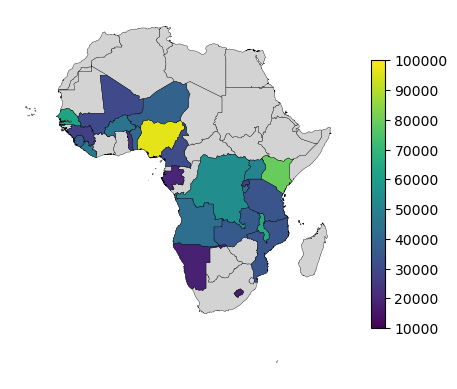

In [8]:
fig, ax = plt.subplots()# dpi=300)
ax.axis('off')

africa.plot(ax=ax, edgecolor="black", facecolor='lightgray', lw=0.25) 

vmin, vmax = 10000, 100000

print('Children surveys per country')
_ = to_plot.plot(ax=ax, edgecolor="black", cmap = 'viridis', column = 'dhs_children',  lw=0.25, vmin = vmin, vmax = vmax, 
            # legend=True,
            # legend_kwds={"shrink":.9},
            )

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)


# Correlation between dimensions

In [51]:
hexes_dhs_no_neigh = hexes_dhs[hexes_dhs['deprived_sev'].isna()==False].copy()
hexes_dhs_no_neigh.shape

(12468, 163)

In [13]:
dimensions = ['sumpoor_sev', 'dep_housing_sev', 'dep_water_sev',
       'dep_sanitation_sev', 'dep_nutrition_sev', 'dep_health_sev',
       'dep_education_sev', 'deprived_sev']
labels = ['depth', 'housing', 'water', 'sanitation', 'nutrition', 'health', 'education', 'prevalence']

In [11]:
corr_no_neigh = hexes_dhs_no_neigh[dimensions].corr()

<AxesSubplot:>

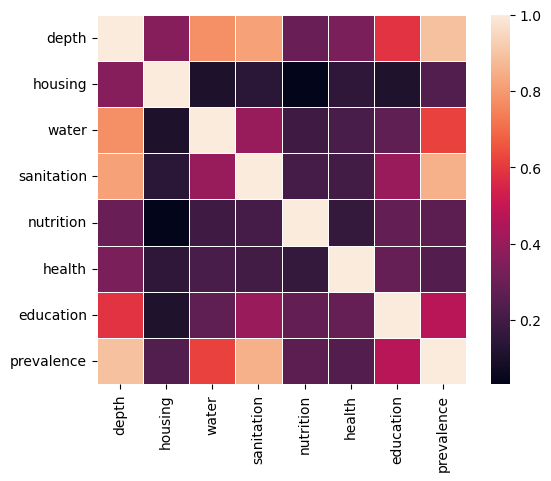

In [17]:
sns.heatmap(corr_no_neigh,
            square=True,
            xticklabels=labels, yticklabels=labels,
            linewidth=.5)

# Add hexcode to raw

In [30]:
raw.dropna(subset=['LATNUM'], inplace=True)
raw.shape

(2369393, 26)

In [31]:
raw = geo.get_hex_code(raw, 'LATNUM', 'LONGNUM', 7)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [43]:
# raw.groupby('hex_code', as_index=False)[dimensions].agg('mean')

In [41]:
grouped_count = raw.groupby('hex_code', as_index=False)[dimensions].agg('count')
grouped_count.rename(columns= {'sumpoor_sev':'sumpoor_count', 'dep_housing_sev':'dep_housing_count',
                        'dep_water_sev':'dep_water_count', 'dep_sanitation_sev':'dep_sanitation_count',
                        'dep_nutrition_sev':'dep_nutrition_count', 'dep_health_sev':'dep_health_count',
                        'dep_education_sev':'dep_education_count', 'deprived_sev':'deprived_count'}, inplace=True)


In [42]:
hexes_dhs = pd.merge(hexes_dhs, grouped_count, how='left', on='hex_code')

In [46]:
hexes_dhs.head(2)

,hex_code,name_commuting,win_population_commuting,win_roads_km_commuting,area_commuting,n_conflicts,geometry,length_km,area_km2,road_density,avg_d_kbps,avg_u_kbps,GSM,LTE,UMTS,avg_signal,elevation,evapotrans,ndvi,ndwi,avg_rad,cf_cvg,pdsi,Optical_Depth_047,Optical_Depth_055,precimean,precistd,slope,2019gdp,africa,ec2019,GDP_PPP_1990,GDP_PPP_2000,GDP_PPP_2015,child_pop,rwi,rwi_error,survey,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,age,hhweight,sumpoor_sev,dep_housing_sev,dep_water_sev,dep_sanitation_sev,dep_nutrition_sev,dep_health_sev,dep_education_sev,deprived_sev,region,region2,latnum,longnum,dep_2_or_more_sev,dep_3_or_more_sev,dep_4_or_more_sev,hex_centroid,year_mean_neigh,round_mean_neigh,cluster_mean_neigh,hhid_mean_neigh,indid_mean_neigh,location_mean_neigh,sex_mean_neigh,wealth_mean_neigh,wealthscore_mean_neigh,age_mean_neigh,hhweight_mean_neigh,sumpoor_prev_neigh,sumpoor_count_neigh,housing_prev_neigh,housing_count_neigh,water_prev_neigh,water_count_neigh,sanitation_prev_neigh,sanitation_count_neigh,nutrition_prev_neigh,nutrition_count_neigh,health_prev_neigh,health_count_neigh,education_prev_neigh,education_count_neigh,deprived_sev_mean_neigh,deprived_sev_count_neigh,region_mean_neigh,region2_mean_neigh,latnum_mean_neigh,longnum_mean_neigh,2_or_more_prev_neigh,2_or_more_count_neigh,3_or_more_prev_neigh,3_or_more_count_neigh,4_or_more_prev_neigh,4_or_more_count_neigh,precipiacc,cnfd,accessibility,accessibility_walking_only,population,M_0,M_1,M_5,M_10,M_15,M_30,M_20,M_25,M_35,M_40,M_45,M_50,M_55,M_60,M_70,M_75,M_65,M_80,F_0,F_1,F_5,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_60,F_50,F_55,F_65,F_70,F_75,F_80,country_code,country,NR,CDMA,hex_code_str,water_surface,no_built,build_2000_2014,build_1990_2000,build_1975_1990,build_prior_1975,largest,sumpoor_count,dep_housing_count,dep_water_count,dep_sanitation_count,dep_nutrition_count,dep_health_count,dep_education_count,deprived_count
0,610276395859312639,cabinda,1.328792e+06,18139.152803,9605.344439,0.0,"((12.732904100477812, -4.623059167412168), (12...",10.689607,5.311200,2.012654,NaN,NaN,0.0,0.0,0.0,NaN,211.45454,727.532504,0.343543,0.282376,0.157719,2.329546,1382.3182,382.359320,274.391760,0.127455,0.148234,5.437882,NaN,0.001981,NaN,NaN,NaN,NaN,6.167462,-0.336534,0.228155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-4.615699589011692, 12.722683696731998)",2015.0,71.0,77.000000,13.196721,4.360656,2.0,1.557377,2.934426,25245.852459,6.770492,0.392661,1.327869,61.0,0.114754,61.0,0.770492,61.0,0.409836,61.0,0.000000,12.0,0.000000,15.0,0.054054,37.0,0.770492,61.0,1.0,NaN,-4.653519,12.731428,0.475410,61.0,0.081967,61.0,0.0,61.0,2987.668259,0.000000,11.793229,71.0,12.868066,0.188045,0.789752,0.823278,0.797216,0.688460,0.413089,0.560355,0.533317,0.298992,0.242842,0.194163,0.193840,0.205593,0.102158,0.040404,0.022762,0.092256,0.013325,0.188357,0.791061,0.881214,0.853318,0.736909,0.662420,0.630457,0.488330,0.353451,0.287074,0.178695,0.094020,0.178397,0.189214,0.084906,0.037185,0.020948,0.012264,AGO,Angola,NaN,NaN,87823260dffffff,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,610276262933430271,cabinda,1.328792e+06,18139.152803,9605.344439,0.0,"((12.219237535243943, -5.6090981921783225), (1...",37.112027,5.311707,6.986836,15717.0,6479.0,1.0,0.0,0.0,0.0,68.95238,646.698793,0.215418,0.079168,5.743694,4.614418,1458.4762,364.300402,260.929612,0.127418,0.126591,5.127139,NaN,0.043447,NaN,435346.72,346996.25,4316442.5,297.571244,0.716460,0.509262,229.0,2015.0,71.0,313.541485,14.218341,5.100437,1.0,1.480349,3.733624,88895.668122,7.161572,0.614931,0.484716,0.135371,0.063636,0.148472,0.0,0.035714,0.201342,0.388646,1.0,NaN,-5.599547,12.20373,0.09607,0.0,0.0,"(-5.601659871826836, 12.20904389095013)",2015.0,71.0,292.231527,14.064039,5.009852,1.0,1.507389,3.815271,95529.032020,7.600985,0.568976,0.426108,406.0,0.160099,406.0,0.035264,397.0,0.083744,406.0,0.015873,63.0,0.053191,94.0,0.197080,274.0,0.357143,406.0,

In [ ]:
'dep_2_or_more_sev', 'dep_3_or_more_sev',
       'dep_4_or_more_sev'

# Missing values of dimensions

## no neigh

In [52]:
d = {}
for col in dimensions:
    col_count = re.sub('_sev', '_count', col)
    num_no_na = hexes_dhs_no_neigh[(hexes_dhs_no_neigh[col].isna()==False) & (hexes_dhs_no_neigh[col_count]>30)].shape[0]
    d[col] = num_no_na

/tmp/ipykernel_354/642795611.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(labels)


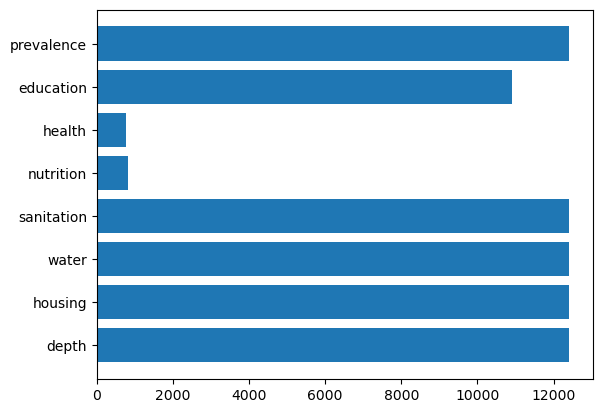

In [60]:
fig, ax = plt.subplots()# dpi=300)

plt.barh(list(d.keys()), list(d.values()))
_ = ax.set_yticklabels(labels)


## neigh

In [66]:
dimensions_neigh = ['sumpoor_prev_neigh',
       'housing_prev_neigh','water_prev_neigh',
       'sanitation_prev_neigh',
       'nutrition_prev_neigh', 'health_prev_neigh',
       'education_prev_neigh',
       'deprived_sev_mean_neigh']

In [68]:
d_neigh = {}
for col in dimensions_neigh:
    col_count = re.sub('(prev|mean)', 'count', col)
    num_no_na = hexes_dhs[(hexes_dhs[col].isna()==False) & (hexes_dhs[col_count]>30)].shape[0]
    d_neigh[col] = num_no_na

/tmp/ipykernel_354/608238936.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(labels)


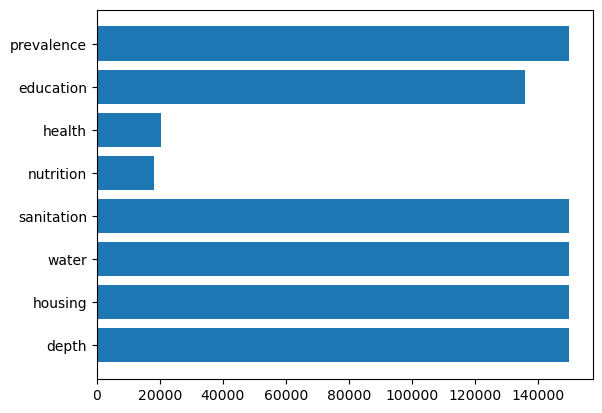

In [69]:
fig, ax = plt.subplots()# dpi=300)

plt.barh(list(d_neigh.keys()), list(d_neigh.values()))
_ = ax.set_yticklabels(labels)
